In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from qutip import (about, basis, destroy, mesolve, ptrace, qeye,
                   tensor, wigner, anim_wigner)
# set a parameter to see animations in line
from matplotlib import rc
import qutip as qp
rc('animation', html='jshtml')

%matplotlib inline

# simulation
## Vacuum Rabi oscillations in the Jaynes-Cummings model
https://nbviewer.org/urls/qutip.org/qutip-tutorials/tutorials-v5/lectures/Lecture-1-Jaynes-Cumming-model.ipynb

$H = \hbar \omega_c a^{\dagger} a + \frac{1}{2} \hbar \omega_a \sigma_z + \hbar g (a^{\dagger} + a)(\sigma_- + \sigma_+)$ 

after rotating-wave approximation

$H_{\text{RWA}} = \hbar \omega_c a^{\dagger} a + \frac{1}{2} \hbar \omega_a \sigma_z + \hbar g (a^{\dagger} \sigma_- + a \sigma_+)$

$\omega_c $ and $\omega_a$ are the frequencies of the cavity and atom, respectively, and g is the interaction strength, $\hbar = 1$

In [2]:
def rabi_detuning(wc,wa, tlist):
	g = 0.5 * 2 * np.pi  # coupling strength
	kappa = 0.005  # cavity dissipation rate
	gamma = 0.05  # atom dissipation rate
	N = 4  # number of cavity fock states
	n_th_a = 0.0  # avg number of thermal bath excitation
	use_rwa = True
	# tlist = np.linspace(0, 25, 101)

	psi0 = tensor(basis(N, 0), basis(2, 1))  # start with an excited atom

	# operators
	a = tensor(destroy(N), qeye(2))
	sm = tensor(qeye(N), destroy(2))

	# Hamiltonian
	if use_rwa:
		H = wc * a.dag() * a + wa * sm.dag() * sm + \
			g * (a.dag() * sm + a * sm.dag())
	else:
		H = wc * a.dag() * a + wa * sm.dag() * sm + \
			g * (a.dag() + a) * (sm + sm.dag())
	c_ops = []

	# cavity relaxation
	rate = kappa * (1 + n_th_a)
	if rate > 0.0:
		c_ops.append(np.sqrt(rate) * a)

	# cavity excitation, if temperature > 0
	rate = kappa * n_th_a
	if rate > 0.0:
		c_ops.append(np.sqrt(rate) * a.dag())

	# qubit relaxation
	rate = gamma
	if rate > 0.0:
		c_ops.append(np.sqrt(rate) * sm)
	output = mesolve(H, psi0, tlist, c_ops, [a.dag() * a, sm.dag() * sm])
	return(output.expect[0], output.expect[1])

In [3]:
wc = 1.1 * 2 * np.pi  # cavity frequency
wa = 1.0 * 2 * np.pi  # atom frequency
g = 0.05 * 2 * np.pi  # coupling strength
kappa = 0.005  # cavity dissipation rate
gamma = 0.05  # atom dissipation rate
N = 4  # number of cavity fock states
n_th_a = 0.0  # avg number of thermal bath excitation
use_rwa = True

tlist = np.linspace(0, 25, 101)

In [4]:
# intial state
psi0 = tensor(basis(N, 0), basis(2, 1))  # start with an excited atom

# operators
a = tensor(destroy(N), qeye(2))
sm = tensor(qeye(N), destroy(2))

# Hamiltonian
if use_rwa:
    H = wc * a.dag() * a + wa * sm.dag() * sm + \
        g * (a.dag() * sm + a * sm.dag())
else:
    H = wc * a.dag() * a  + wa * sm.dag() * sm + \
        g * (a.dag() + a) * (sm + sm.dag())

In [5]:
c_ops = []

# cavity relaxation
rate = kappa * (1 + n_th_a)
if rate > 0.0:
    c_ops.append(np.sqrt(rate) * a)

# cavity excitation, if temperature > 0
rate = kappa * n_th_a
if rate > 0.0:
    c_ops.append(np.sqrt(rate) * a.dag())

# qubit relaxation
rate = gamma
if rate > 0.0:
    c_ops.append(np.sqrt(rate) * sm)

In [6]:
output = mesolve(H, psi0, tlist, c_ops, [a.dag() * a, sm.dag() * sm])

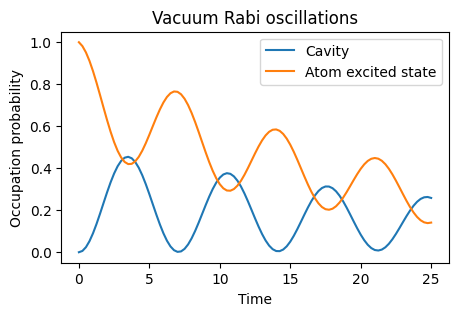

In [7]:
n_c = output.expect[0]
n_a = output.expect[1]

fig, axes = plt.subplots(1, 1, figsize=(5, 3))

axes.plot(tlist, n_c, label="Cavity")
axes.plot(tlist, n_a, label="Atom excited state")
axes.legend(loc=0)
axes.set_xlabel("Time")
axes.set_ylabel("Occupation probability")
axes.set_title("Vacuum Rabi oscillations");


In [8]:
n_a.shape
fre_list = np.linspace(1,15,201)
tlist = np.linspace(0, 100, 101)


all = []
for fre in fre_list:
    fre = fre * 2 * np.pi
    all.append(rabi_detuning(fre, 4.0 * 2 * np.pi, tlist=tlist)[1])

all = np.array(all)

/var/folders/z9/zsb0ck7s4bxd7nwf3h60xzxw0000gn/T/ipykernel_25101/551715306.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


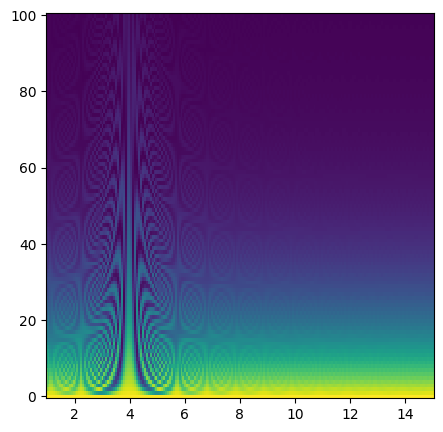

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
heatmap = ax.pcolor(fre_list, tlist, all.T)
fig.show()

## Qubit-Qubit Model
$H = \frac{1}{2} \hbar \omega_a \sigma_z + \frac{1}{2} \hbar \omega_b \sigma_z + \hbar g ({\sigma}^{\dagger} - \sigma) ( \sigma - {\sigma}^{\dagger} )$ 


In [10]:
def dress(wa, wb, J, tlist):
    
	sz1 = tensor(qp.sigmaz(), qp.identity(2))  # 第一个量子比特的σz
	sz2 = tensor(qp.identity(2), qp.sigmaz())  # 第二个量子比特的σz
	sy1 = tensor(qp.sigmay(), qp.identity(2))  # 第一个量子比特的σy
	sy2 = tensor(qp.identity(2), qp.sigmay())  # 第二个量子比特的σy

	# 构建哈密顿量
	H0 = 0.5*wa*sz1 + 0.5*wb*sz2  # 自由哈密顿量

	H_g = J * tensor(qp.sigmay(), qp.sigmay())                
	H = H0 + H_g 


	# 定义初始态为 |00⟩
	psi0 = tensor(basis(2,1), basis(2,0))
	
	# 进行时间演化（无耗散）
	result = mesolve(H, psi0, tlist, [], [])

	# 定义投影算符用于计算布居数
	proj_00 = tensor(basis(2,0).proj(), basis(2,0).proj())
	proj_01 = tensor(basis(2,0).proj(), basis(2,1).proj())
	proj_10 = tensor(basis(2,1).proj(), basis(2,0).proj())
	proj_11 = tensor(basis(2,1).proj(), basis(2,1).proj())

	pop_00 = qp.expect(proj_00, result.states)
	pop_01 = qp.expect(proj_01, result.states)
	pop_10 = qp.expect(proj_10, result.states)
	pop_11 = qp.expect(proj_11, result.states)

	return (pop_00, pop_01, pop_10, pop_11 )


In [11]:
wa = 10
wb = 4
J=0.2
sz1 = tensor(qp.sigmaz(), qp.identity(2))  # 第一个量子比特的σz
sz2 = tensor(qp.identity(2), qp.sigmaz())  # 第二个量子比特的σz
sy1 = tensor(qp.sigmay(), qp.identity(2))  # 第一个量子比特的σy
sy2 = tensor(qp.identity(2), qp.sigmay())  # 第二个量子比特的σy

# 构建哈密顿量
H0 = 0.5*wa*sz1 + 0.5*wb*sz2  # 自由哈密顿量

H_g = J * tensor(qp.sigmay(), qp.sigmay())                
H = H0 + H_g 
H

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 7.   0.   0.  -0.2]
 [ 0.   3.   0.2  0. ]
 [ 0.   0.2 -3.   0. ]
 [-0.2  0.   0.  -7. ]]

In [12]:
sm = tensor(qeye(N), destroy(2))


In [13]:
destroy(2)

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dia, isherm=False
Qobj data =
[[0. 1.]
 [0. 0.]]

In [14]:
qp.create(2) 

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dia, isherm=False
Qobj data =
[[0. 0.]
 [1. 0.]]

In [15]:
width, height = 256,256
fre_list = np.linspace(0, 8, width) 
tlist = np.linspace(0, 10, height)
wb = 6 * 2*np.pi
g = 0.5 * 2 * np.pi 

all = []
for fre in fre_list:
    wa = fre * 2 * np.pi
    all.append(dress(width, height, wa, wb, g, tlist=tlist)[1])

all = np.array(all)

TypeError: dress() got multiple values for argument 'tlist'

/var/folders/z9/zsb0ck7s4bxd7nwf3h60xzxw0000gn/T/ipykernel_2256/551715306.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


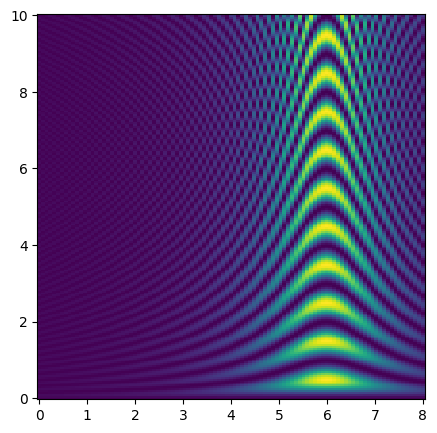

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
heatmap = ax.pcolor(fre_list, tlist, all.T)
fig.show()

In [17]:
# tlist 从0-10, fre 从1-10
def generate_detuning(width, height, wb, J):
    
	tlist = np.linspace(0,10,height)
	fre_list = np.linspace(0,10,width)

	all = []
	for fre in fre_list:
		wa = fre * 2 * np.pi
		all.append(dress(wa, wb, J, tlist=tlist)[1])

	all = np.array(all)
	return all

In [20]:

import pandas as pd
df = pd.DataFrame(columns=['wb', 'g', 'datas'])
np.random.seed(3)
fre_list = np.random.uniform(0, 10*2*np.pi,size=1000)
g_list = np.random.uniform(0, 20*2*np.pi, size=1000)
for i in range(1000):
        fre = fre_list[i]
        g = g_list[i]
        print(i)
        df.loc[len(df)] = [fre, g, generate_detuning(256,256,wb=fre ,J=g)]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [21]:
df.to_csv('data.csv')

/var/folders/z9/zsb0ck7s4bxd7nwf3h60xzxw0000gn/T/ipykernel_2256/1204187590.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


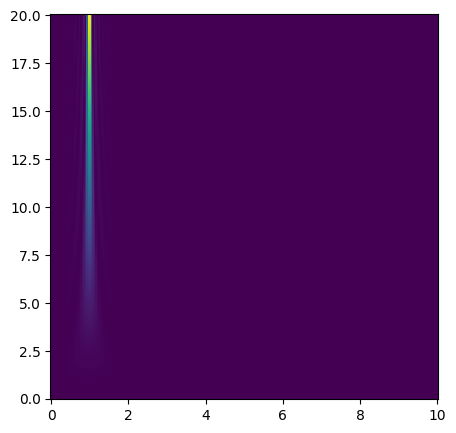

In [ ]:
width, height = 256,256
tlist = np.linspace(0,10,height)
fre_list = np.linspace(0,10,width)
all = np.array(generate_detuning(256, 256, wb = 1*2*np.pi, J = 0.01 * 2 * np.pi))
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
heatmap = ax.pcolor(fre_list, tlist, all.T)
fig.show()

# Generate Data

In [136]:
import torch
from torch.utils.data import Dataset

class detuningDataset(Dataset):
    def __init__(self, num_samples, height, width):
        self.num_samples = num_samples
        self.height = height
        self.width = width
        
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        # 随机生成参数（示例范围）
        wb = np.random.uniform(0, 10*2*np.pi)
        J =  np.random.uniform(0, 20*2*np.pi)

        
        # 生成图像
        image = generate_detuning(self.height, self.width, wb, J)
        
        # 转换为Tensor
        image_tensor = torch.from_numpy(image).float().permute(0, 1)  # (C, H, W)
        image_tensor = image_tensor.unsqueeze(0) 
        params = torch.tensor([wb, J], dtype=torch.float32)
        
        return image_tensor, params

# 示例数据集
dataset = detuningDataset(num_samples=6, height=256, width=256)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

In [137]:
test_sample, _ = dataset[0]
print("输入形状:", test_sample.shape)  

输入形状: torch.Size([1, 256, 256])


In [138]:
import torch.nn as nn

class ParamPredictor(nn.Module):
    def __init__(self):
        super(ParamPredictor, self).__init__()
        
        # 卷积层处理图像和坐标
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),  # 输入通道数为1，适用于单一特征图
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(10, 16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        # 全连接层预测参数
        self.fc_layers = nn.Sequential(
            nn.Linear(32 * 30 * 30, 256),  # 根据实际池化后的尺寸调整输入特征数
            nn.ReLU(),
            nn.Dropout(p=0.5),               # 添加丢弃率防止过拟合
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, 2)                # 输出两个参数，修正注释错误
        )
        
    def forward(self, x):
        out = self.conv_layers(x)
        out = out.view(-1, 32 * 30 * 30)     # Flatten tensor to 1D
        out = self.fc_layers(out)
        return out

# 初始化模型
model = ParamPredictor()

In [139]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [140]:
num_epochs = 6

for epoch in range(num_epochs):
    for batch_idx, (images, params) in enumerate(dataloader):
        # 前向传播
        outputs = model(images)
        loss = criterion(outputs, params)
        
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # 打印训练信息
        if batch_idx % 50 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(dataloader)}], Loss: {loss.item():.4f}')

Epoch [1/10], Batch [0/1], Loss: 2778.7681
Epoch [2/10], Batch [0/1], Loss: 2449.7974
Epoch [3/10], Batch [0/1], Loss: 3903.1646
Epoch [4/10], Batch [0/1], Loss: 3020.0540
Epoch [5/10], Batch [0/1], Loss: 2514.9626
Epoch [6/10], Batch [0/1], Loss: 2137.3662
Epoch [7/10], Batch [0/1], Loss: 1545.6835
Epoch [8/10], Batch [0/1], Loss: 1352.0986
Epoch [9/10], Batch [0/1], Loss: 705.0460
Epoch [10/10], Batch [0/1], Loss: 3049.1680


In [143]:
# 生成测试数据
test_dataset = detuningDataset(num_samples=100, height=256, width=256)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

model.eval()
total_loss = 0
with torch.no_grad():
    for images, params in test_loader:
        outputs = model(images)
        loss = criterion(outputs, params)
        total_loss += loss.item()

print(f'Test Loss: {total_loss / len(test_loader):.4f}')

Test Loss: 924.3500


/var/folders/z9/zsb0ck7s4bxd7nwf3h60xzxw0000gn/T/ipykernel_2256/1263096251.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


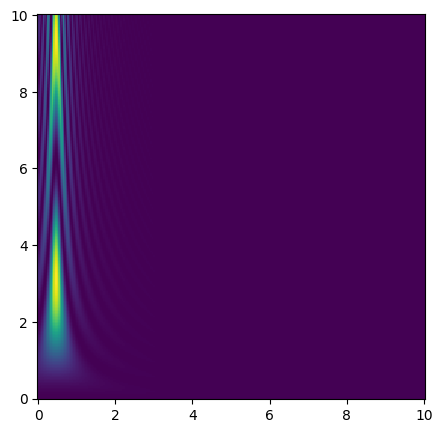

In [146]:
all = generate_detuning(256, 256, 3, 0.5)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
heatmap = ax.pcolor(fre_list, tlist, all.T)
fig.show()

In [150]:

image = generate_detuning(256, 256, 3, 0.5)
        
# 转换为Tensor
image_tensor = torch.from_numpy(image).float().permute(0, 1)  # (C, H, W)
image_tensor = image_tensor.unsqueeze(0) 

In [151]:
model(image_tensor)

tensor([[11.1292, 20.9420]], grad_fn=<AddmmBackward0>)

In [152]:
torch.save(model, "detuning-v1.pth")